# Noise to cascade evaluation

this notebook is thought to provide an overview that compares the noise records with the event records and combined records to check which records to include for training

In [1]:
%load_ext autoreload
%autoreload 2
from ananke.models.collection import Collection
from ananke.configurations.collection import HDF5StorageConfiguration

In [2]:
cascades_configuration = HDF5StorageConfiguration(data_path='../../data/new_collection/cascades_10.h5', read_only=True)
cascades_collection = Collection(cascades_configuration)
noise_configuration = HDF5StorageConfiguration(data_path='../../data/electrical_noise_100000/data.h5', read_only=True)
noise_collection = Collection(noise_configuration)
bioluminescense_configuration = HDF5StorageConfiguration(data_path='../../data/bioluminescence_100/data.h5', read_only=True)
bioluminescense_collection = Collection(bioluminescense_configuration)
combined_noise_configuration = HDF5StorageConfiguration(data_path='../../data/merge/combined_noise_overlap_10000.h5', read_only=True)
combined_noise_collection = Collection(combined_noise_configuration)

In [3]:
with cascades_collection:
    records = cascades_collection.storage.get_records()
    sources = cascades_collection.storage.get_hits(record_ids=[records.record_ids[2]])
    cascades_record_statistics = cascades_collection.get_record_statistics()
    #cascade_hit_counts = cascades_record_statistics.df['hit_count']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 43.68it/s]

count=9320 min=251.73064719549754 max=297.88445817343336
count=12413 min=690.4705725433838 max=733.9656079533112
count=346 min=429.3175458742744 max=457.13327596918407
count=86004 min=615.6478394530019 max=659.7047556898793
count=79 min=385.2339005910923 max=401.984725519376
cool


46.15381097793582


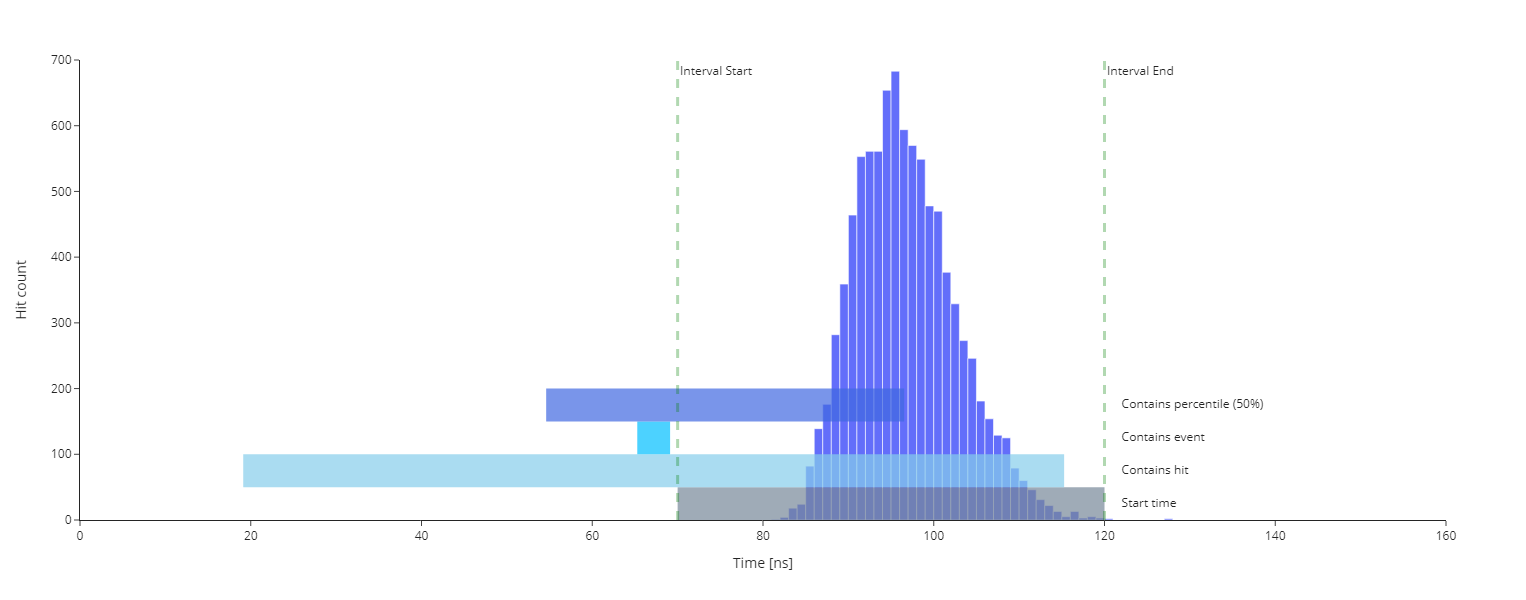

In [108]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

with cascades_collection:
    hits = cascades_collection.storage.get_hits(record_ids=records.record_ids[2])
    
left_shift=170
interval_start=70
interval_end=120
current_time=records.times[2] - left_shift
text_offset=2
min=hits.times.min() - left_shift
max=hits.times.max() - left_shift
print(length)
text_height=50
offset = min - current_time
hit_statistics = hits.get_statistics(percentile=.5)
stat_min = hit_statistics.min - left_shift
stat_max = hit_statistics.max - left_shift
stat_len = stat_max-stat_min
stat_offset = stat_min - current_time

fig = px.histogram(hits.times - left_shift, nbins=64)
fig.add_trace(go.Scatter(
    x=np.array([interval_end, interval_end, interval_end, interval_end]) + text_offset,
    y=[text_height/2,text_height*1.5,text_height*2.5,text_height*3.5],
    text=["Start time", "Contains hit", "Contains event", "Contains percentile (50%)"],
    mode="text",
    textposition="middle right"
))
fig.add_shape(type="rect",
    x0=interval_start, y0=0, x1=interval_end, y1=text_height,
    layer="above",
    fillcolor="LightSlateGray",
    opacity=1
)
fig.add_shape(type="rect",
    x0=interval_start - max + current_time, y0=text_height, x1=interval_end - min + current_time, y1=text_height*2,
    layer="above",
    fillcolor="SkyBlue",
    opacity=1
)
fig.add_shape(type="rect",
    x0=interval_start - offset, y0=text_height*2, x1=interval_end - offset - length, y1=text_height*3,
    layer="above",
    fillcolor="DeepSkyBlue",
    opacity=1
)
fig.add_shape(type="rect",
    x0=interval_start - stat_offset, y0=text_height*3, x1=interval_end - stat_offset - stat_len, y1=text_height*4,
    layer="above",
    fillcolor="RoyalBlue",
    opacity=1
)
fig.update_shapes(opacity=0.7, xref="x", yref="y")
fig.add_vline(x=interval_start, line_width=3, line_dash="dash", line_color="green", annotation=dict(text='Interval Start'))
fig.add_vline(x=interval_end, line_width=3, line_dash="dash", line_color="green", annotation=dict(text='Interval End'))
fig.update_xaxes(autorange=False, range=[0,160], showticklabels=True, title_text='Time [ns]')
fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    template='simple_white',
    yaxis_title="Hit count",
    yaxis_range=[0,700],
    showlegend=False
)
fig.write_image('redistribution_mode.png', scale=3)
fig.show()


In [ ]:
noise_record_statistics = noise_collection.get_record_statistics()
noise_hit_counts = noise_record_statistics.df['hit_count']

In [6]:
bioluminescence_record_statistics = bioluminescense_collection.get_record_statistics()
bioluminescence_hit_counts = bioluminescence_record_statistics.df['hit_count']

ValueError: You forgot to open the storage

In [ ]:
combined_noise_record_statistics = combined_noise_collection.get_record_statistics()
combined_noise_hit_counts = combined_noise_record_statistics.df['hit_count']

In [ ]:
cascade_hit_counts = cascades_record_statistics.df['hit_count']

In [ ]:
print(len(cascade_hit_counts))
cascade_hit_counts.plot.hist(bins=100, logy=True, xlim=(0,10000000))

In [ ]:
noise_hit_counts.plot.hist(bins=20)

With these statistics, we can tell that after a given amount of hits, it is not really probable that it is a noise event. Let's go for 5 sigma

In [ ]:
bioluminescence_hit_counts.plot.hist(bins=100, xlim=(0,1000))

In [ ]:
combined_noise_hit_counts.plot.hist(bins=100)

In [ ]:

one_sigma = 0.682689492137064
three_sigma = 0.997300203936740
five_sigma = 0.999999426696856


combined_noise_quantile = combined_noise_hit_counts.quantile(one_sigma)

In [ ]:
noise_mean = noise_hit_counts.mean()
noise_std = noise_hit_counts.std()

In [ ]:
five_sigma = noise_mean + 5 * noise_std
five_sigma

Based on 100.000 electronical noise records, everything with more than 87 hits is most likely to be a event. Hence, we can limit our efforts on events below this threshold.

In [ ]:
feasible_cascades_df = cascades_record_statistics.df
feasible_cascades_df = feasible_cascades_df[feasible_cascades_df['hit_count'] < combined_noise_three_sigma]

In [ ]:
feasible_cascades_df.head()

In [ ]:
len(feasible_cascades_df.index)

In [ ]:
feasible_cascades_df.reset_index().to_feather('../../data/combined_noise_feasable_cascades.feather')

In [43]:
len(feasible_cascades_df.index)

2290

In [45]:
feasible_cascades_df.reset_index().to_feather('../../data/combined_noise_feasable_cascades.feather')